### This script connects to a MongoDB database, downloads stock data, preprocesses it, and uploads it to the database.

Steps:

1. Read in CSV file 'Complete-List-of-Listed-Companies-on-Singapore-Stock-Exchange-052923.csv' to extract Trading Name and Code columns. These represent the stock symbols we're interested in.
2. Append '.SI' to the end of each Code. This is required because the yFinance API uses '.SI' to denote stocks listed on the Singapore Exchange.
3. Establish a connection to the MongoDB database using the connection string from 'config.env'.
4. Download stock data for each symbol from the yFinance API. If a symbol is delisted or unavailable, it is skipped and a warning message is printed.
5. Preprocess the downloaded data by converting it to a time-series format and setting appropriate column names.
6. Upload the preprocessed data to the MongoDB database. Each symbol's data is uploaded as a separate document in the 'ticker_data' collection.

In [14]:
# Import necessary libraries
import yfinance as yf
from pymongo import MongoClient
from datetime import datetime
import matplotlib.pyplot as plt
import pymongo
import pandas as pd
import requests
from bson import ObjectId

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTMCell, LSTM
from tensorflow.keras.models import load_model, save_model
from tensorflow import function
from bson.binary import Binary
import pickle
from dotenv import load_dotenv



/Users/darrels/miniforge3/envs/tf_env/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


### Uploading data to MongoDB

#### Steps:
1. Establish a connection to the MongoDB database using the connection string from 'config.env'.
2. Upload the preprocessed data to the MongoDB database. Each symbol's data is uploaded as a separate document in the 'ticker_data' collection.

In [15]:
# Read in the data from the csv file
path = "../../Data/Complete-List-of-Listed-Companies-on-Singapore-Stock-Exchange-052923.csv"

# Read the data into a DataFrame
SGXdf = pd.read_csv(path)
SGXdf.head()

,S.No.,Trading Name,Code,Sector
0,1,3Cnergy,502,Real Estate
1,2,5E Resources,NLC,Industrial & Commercial Services
2,3,8Telecom,AZG,Technology Equipment
3,4,9R,1Y1,Industrial Goods
4,5,ABR,533,Food & Beverages


In [16]:
# Add the .SI to the end of each symbol in the dataframe
# symbols = [symbol + '.SI' for symbol in symbols]
# symbols

# Add the .SI to the end of each symbol in the dataframe
SGXdf['Code'] = SGXdf['Code'] + '.SI'
SGXdf.head()

# Get the unique sectors
symbols = SGXdf['Code'].unique()
# Convert numpy array to list
symbols_list = symbols.tolist()

In [37]:
# Define the stock symbols and time range
symbols = ['U96.SI']
symbols_list = symbols
print(symbols_list)

['U96.SI']


In [18]:
# Find the matching row in SGXdf for the current symbol
matched_row = SGXdf[SGXdf['Code'] == 'U96.SI']

matched_row

,S.No.,Trading Name,Code,Sector
498,499,Sembcorp Ind,U96.SI,Utilities


In [53]:
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv
import pymongo
import yfinance as yf

# Load the .env file
load_dotenv('../server/config.env')

# Get the connection string
connection_string = os.getenv('ATLAS_URI')

client = pymongo.MongoClient(connection_string)
db = client['bullsai']
collection = db['ticker_data']

# Get the latest end date and transaction count in the collection
latest_record = db.ticker_data.find().sort("bucket_end_date", pymongo.DESCENDING).limit(1)

if latest_record.count() > 0:
    latest_end_date = latest_record[0]["bucket_end_date"]
    latest_transaction_count = latest_record[0]["transaction_count"]
else:
    latest_end_date = "2000-01-01"  # If no data is available, use a default start date
    latest_transaction_count = 0

# Fetch data from yFinance from the day after the latest end date until today
# start_date = (datetime.strptime(latest_end_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
start_date = "2000-01-03"
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch data from yFinance for the list of symbols
data = yf.download(symbols_list, start=start_date, end=end_date)

# Reset index to make the Date column accessible
data.reset_index(inplace=True)

# Preprocess the data
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data['Date'] = data['Date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))


# Update transactions for each symbol
# Fetch data from yFinance for the list of symbols
for symbol in symbols_list:
    # Fetch data from yFinance for the current symbol
    data = yf.download(symbol, start=start_date, end=end_date)

    # Reset index to make the Date column accessible
    data.reset_index(inplace=True)

    # Preprocess the data
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    data['Date'] = data['Date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))


    # Check if the symbol exists in the collection
    symbol_exists = db.ticker_data.find_one({"symbol": symbol})

    if symbol_exists:
        # Find the matching row in SGXdf for the current symbol
        matched_row = SGXdf[SGXdf['Code'] == symbol]
        print(matched_row)

        if not matched_row.empty:
            trading_name = matched_row['Trading Name'].values[0]
            transactions = data.drop(columns=['Symbol']).to_dict('records')

            # Update existing document
            db.ticker_data.update_one(
                {"symbol": symbol},
                {"$push": {"transactions": {"$each": transactions}},
                 "$set": {"transaction_count": len(transactions),
                          "bucket_start_date": data['Date'].min(),
                          "bucket_end_date": data['Date'].max(),
                          "trading_name": trading_name}},
                upsert=True
            )
    else:
        # Insert new document
        db.ticker_data.insert_one({
            "trading_name": trading_name,  # Make sure to define trading_name before this point
            "symbol": symbol,
            "transaction_count": len(data),
            "bucket_start_date": data['Date'].min(),
            "bucket_end_date": data['Date'].max(),
            "transactions": data.to_dict('records')
        })

# Close the MongoDB connection
client.close()


/var/folders/v3/t0psjdhs29g8j3cghfdfjd9w0000gn/T/ipykernel_6097/2917474409.py:20: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if latest_record.count() > 0:


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
     S.No.  Trading Name    Code     Sector
498    499  Sembcorp Ind  U96.SI  Utilities


KeyError: "['Symbol'] not found in axis"

In [25]:
symbols_list

['U96.SI']

In [51]:
# Connect to MongoDB

# Create a client
# Read the connection string from the config.env file
# Load the .env file
load_dotenv('../server/config.env')

# Get the connection string
connection_string = os.getenv('ATLAS_URI')

client = pymongo.MongoClient(connection_string)
db = client['bullsai']
collection = db['ticker_data']

# Define the stock symbols and time range
symbols = symbols_list
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download stock data from yFinance
data = yf.download(symbols, start=start_date, end=end_date)

# Preprocess the data and convert it to a time-series format
data = data.stack().reset_index()
data.columns = ['Date', 'Symbol', 'Value']
data['Date'] = data['Date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))


# Group the data by symbol and create a document for each symbol
for symbol in symbols:
    # Filter data for the current symbol
    symbol_data = data[data['Symbol'] == symbol]
    print(symbol_data)
    
    # Check if the data for the symbol is empty
    if symbol_data.empty:
        print(f"Warning: No data found for symbol {symbol}. It might be delisted.")
        continue

    # Find the matching row in SGXdf for the current symbol
    matched_row = SGXdf[SGXdf['Code'] == symbol]

    if not matched_row.empty:
        trading_name = matched_row['Trading Name'].values[0]
        transactions = symbol_data.drop(columns=['Symbol']).to_dict('records')

        document = {
            "_id": ObjectId(),
            "trading_name": trading_name,
            "symbol": symbol,
            "transaction_count": len(transactions),
            "bucket_start_date": symbol_data['Date'].min(),
            "bucket_end_date": symbol_data['Date'].max(),
            "transactions": transactions
        }

        # Upload the document to MongoDB
        collection.insert_one(document)
    else:
        print(f"Warning: No details found for symbol {symbol}")


# Close the MongoDB connection
client.close()


[*********************100%%**********************]  1 of 1 completed
Empty DataFrame
Columns: [Date, Symbol, Value]
Index: []


In [ ]:
# Connect to MongoDB

# Create a client
# Read the connection string from the config.env file
with open('../server/config.env', 'r') as file:
    connection_string = file.read().strip()

connection_string = connection_string.replace('ATLAS_URI=', '')

client = pymongo.MongoClient(connection_string)
db = client['bullsai']
collection = db['ticker_data']

# Define the stock symbols and time range
symbols = symbols_list
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download stock data from yFinance
data = yf.download(symbols, start=start_date, end=end_date)

# Preprocess the data and convert it to a time-series format
data = data.stack().reset_index()
data.columns = ['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
data['Date'] = data['Date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

# Group the data by symbol and create a document for each symbol
for symbol in symbols:
    # Filter data for the current symbol
    symbol_data = data[data['Symbol'] == symbol]
    
    # Check if the data for the symbol is empty
    if symbol_data.empty:
        print(f"Warning: No data found for symbol {symbol}. It might be delisted.")
        continue

    # Find the matching row in SGXdf for the current symbol
    matched_row = SGXdf[SGXdf['Code'] == symbol]

    if not matched_row.empty:
        trading_name = matched_row['Trading Name'].values[0]
        transactions = symbol_data.drop(columns=['Symbol']).to_dict('records')

        document = {
            "_id": ObjectId(),
            "trading_name": trading_name,
            "symbol": symbol,
            "transaction_count": len(transactions),
            "bucket_start_date": symbol_data['Date'].min(),
            "bucket_end_date": symbol_data['Date'].max(),
            "transactions": transactions
        }

        # Upload the document to MongoDB
        collection.insert_one(document)
    else:
        print(f"Warning: No details found for symbol {symbol}")


# Close the MongoDB connection
client.close()


### Download values from MongoDB
Steps:
1. Connect to MongoDB
2. Query the data
3. Convert the data to a DataFrame
4. Close the MongoDB connection

In [9]:
# Declare Symbol to be used for testing
symbol = 'D05.SI'

In [10]:
# Connect to MongoDB
with open('../server/config.env', 'r') as file:
    connection_string = file.read().strip()

connection_string = connection_string.replace('ATLAS_URI=', '')

client = pymongo.MongoClient(connection_string)
db = client['bullsai']
collection = db['ticker_data']

In [11]:
# Query the data from MongoDB
dataTest = collection.find_one({"symbol": symbol})

#### Preprocessing

The downloaded data is in a format that is not suitable for analysis. It is converted to a time-series format and the column names are set appropriately.

In [12]:
# Convert the data to a DataFrame
dataDF = pd.DataFrame(dataTest['transactions'])
dataDFTest = dataDF.set_index('Date')
dataDFTest.head()
# dataDFTest.info()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-03,11.488713,27.299999,27.500000,27.000000,27.400000,748000.0
2000-01-04,11.067874,26.299999,27.299999,26.000000,27.299999,2405000.0
2000-01-05,10.352468,24.600000,25.799999,24.600000,25.799999,3892000.0
2000-01-06,10.142050,24.100000,25.200001,23.400000,25.000000,2522000.0
2000-01-07,10.520802,25.000000,25.000000,23.799999,24.100000,3649000.0


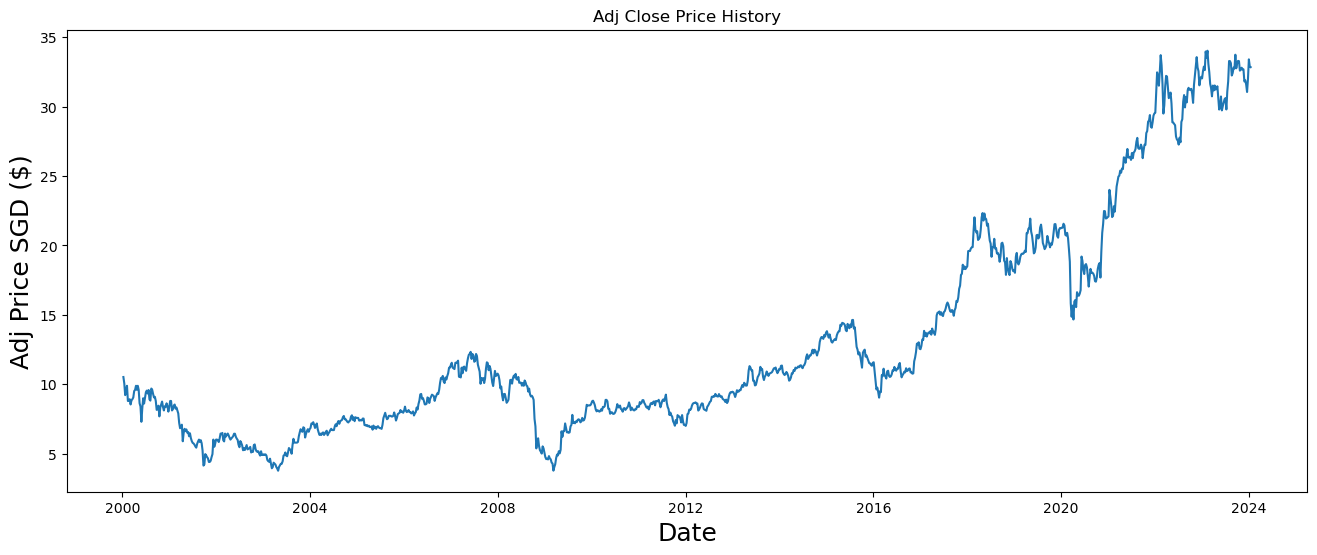

In [13]:
# Ensure your index is a DateTimeIndex
dataDFTest.index = pd.to_datetime(dataDFTest.index)

# Resample to weekly frequency, taking the last price each week
weekly_data = dataDFTest['Adj Close'].resample('W').last()

plt.figure(figsize=(16,6))
plt.title('Adj Close Price History')
plt.plot(weekly_data)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Price SGD ($)', fontsize=18)
plt.show()

#### Functions to call:

In [ ]:
def connect_to_db():
    with open('../server/config.env', 'r') as file:
        connection_string = file.read().strip()

    connection_string = connection_string.replace('ATLAS_URI=', '')

    client = pymongo.MongoClient(connection_string)
    db = client['bullsai']
    return db

def download_data(symbol):
    db = connect_to_db()
    collection = db['ticker_data']
    data = collection.find_one({"symbol": symbol})

    # if data is not None and 'transactions' in data:
    #     df = pd.DataFrame(data['transactions'])
    #     df = df.set_index('Date')
    # else:
    #     print(f"No data found for symbol {symbol}")
    #     df = pd.DataFrame()

    if data is not None and 'transactions' in data:
        # Convert the data to a DataFrame
        dataDF = pd.DataFrame(data['transactions'])
        dataDF = dataDF.set_index('Date')

    return dataDF

def create_dataset(data):
    data = data.filter(['Adj Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset, training_data_len

def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def create_training_data(scaled_data, training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    return np.array(x_train), np.array(y_train)

def reshape_data(x_train):
    return np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def build_and_train_model(x_train, y_train):
    model = Sequential()
    model.add(RNN(LSTMCell(128), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(RNN(LSTMCell(64), return_sequences=False))
    # model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=2)
    return model

def create_test_data(scaled_data, dataset, training_data_len):
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    return np.array(x_test), y_test

def make_predictions(model, x_test, scaler):
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def calculate_rmse(predictions, y_test):
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))

def plot_data(data, training_data_len, predictions, symbol):
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid.loc[:, 'Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title(symbol + ' Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price SGD ($)', fontsize=18)
    plt.plot(train['Adj Close'])
    plt.plot(valid[['Adj Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

def save_model(model, model_path):
    model.save(model_path)

def load_model_if_exists(model_path):
    if os.path.exists(model_path):
        return load_model(model_path)
    else:
        return None
    

def load_model_from_db(symbol):
    # Connect to MongoDB
    db = connect_to_db()
    collection = db['ticker_data']
    doc = collection.find_one({'symbol': symbol})

    if doc is not None:
        print(f"Document found for symbol {symbol}")
        if 'model' in doc:
            print("Model key found in document")
            binary_model = doc['model']
            # Write the binary model to a file
            with open('model.h5', 'wb') as f:
                f.write(binary_model)
            # Load the model from the file
            model = load_model('model.h5')
        else:
            print("Model key not found in document")
            model = None
    else:
        print(f"No document found for symbol {symbol}")
        model = None

    return model

def save_model_to_db(model, symbol):
    # Save the model to a file
    model.save('model.h5')

    # Read the model file and convert it to binary
    with open('model.h5', 'rb') as f:
        binary_model = Binary(pickle.dumps(f.read()))

    # Connect to MongoDB
    db = connect_to_db()
    collection = db['models']

    # Store the binary model in MongoDB
    collection.insert_one({'symbol': symbol, 'model': binary_model})


In [ ]:
symbol = "D05.SI"
data = download_data(symbol)
data

In [ ]:
def main():
    symbol = "U11.SI"
    model_path = f"models/{symbol}_model.h5"
    
    # Use the new download_data function
    data = download_data(symbol)
    dataset, training_data_len = create_dataset(data)
    scaled_data, scaler = scale_data(dataset)
    
    # Use the new load_model_from_db function
    model = load_model_from_db(symbol)

    if model is None:
        print(f"No model found for symbol {symbol}. Please train a model first.")

        # Create the training data
        x_train, y_train = create_training_data(scaled_data, training_data_len, portion=0.1)
        x_train = reshape_data(x_train)

        # Build and train the model
        model = build_and_train_model(x_train, y_train)

        # Save the model to MongoDB
        save_model_to_db(model, symbol)
    else:
        print(f"Model found for symbol {symbol}. Using existing model.")
        return

    x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
    predictions = make_predictions(model, x_test, scaler)
    plot_data(data, training_data_len, predictions, symbol)

if __name__ == "__main__":
    main()